In [1]:
library(dplyr)
library(tidymodels)
library(infer)
library(cowplot)
library(GGally)
library(ggplot2)
library(grid)
library(gridExtra) 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tibble       3.2.1
✔ ggplot2      3.4.4     ✔ tidyr        1.3.0
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/

Registered S3 method overwritten by 'GGally':
  method from  

## Explanatory Data Analysis
The data being explored is the [1994 Census Income Data Set](https://archive.ics.uci.edu/dataset/2/adult) that explores personal annual income in 1994. This data consists of n=32561 observations that contain various numerical and categorical features. This data was obtained through UC Irvine Machine Learning Repository. It was extracted by Barry Becker from the 1994 Census database.  

The variables we have are: 

- V1 =  `age` Continuous Variable (Integer >= 0)
- V2 = `workclass` e.g. Private, Self-emp-not-inc, Self-emp-inc
- V3 = `fnlwgt` Number of people that share the common features from V1 to V15 (excluding V3).
- V4 = `edu` Education Level 
- V5 = `edu_num` Number of years spent in education.
- V6 = `status` Marital Status e.g. Married-civ-spouse, Divorced, Never-married, Separated, Widowed
- V7 = `occupation` e.g. Tech-support, Craft-repair, Other-service, Sales, Exec-manageria
- V8 = `realtionship` e.g. Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
- V9 = `race` White, Asian-Pac-Islander (API), Amer-Indian-Eskimo (AIE), Other, Black
- V10 = `sex`  Female, Male
- V11 = `capital_gain` Continuous Variable (Integer >= 0)
- V12 = `capital_loss` Continuous Variable (Integer >= 0)
- V13 = `hrs` Work Hours Per Week
- V14 = `country` Native Country
- V15 = `income` Whether the income exceeds $50K or not.

__The primary objective of this analysis is to determine how the individual's annual income is associated with various explantory variables such as age, race, capital gain and loss, race, sex, education level and work hours per week.__


### Reading in the data

In [2]:
adult <- read.csv("adult.data", header = F)

colnames(adult) <- c("age", "workclass", "fnlwgt", "education", "edu_num",
                  "status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hrs", "country", "income")

To begin the EDA, the severity of the missing data should be dertermined.

In [3]:
qm_count <- data.frame(qustion_mark__count = sapply(adult, function(y) sum(y == " ?")))
qm_count

,qustion_mark__count
,<int>
age,0
workclass,1836
fnlwgt,0
education,0
edu_num,0
status,0
occupation,1843
relationship,0
race,0


As the above tabel shows, there are 1836 missing observations in `workclass` columns, 1843 in `occupation` and 583 in `country`. The size of these missing values are not large in comparison with the whole dataset. We may proceed with removing these observations to simplify the analysis.


In [4]:
adult_cleaned <- adult %>%
  filter(!if_any(everything(), ~ .x == " ?"))

Since the origninal dataset is a census dataset with large populations and various categories, it is more appropriate to take a sample from it. Taking a random sample can help identify trends, outliers, and potential issues without processing the entire dataset, improving computational efficiency. Meanwhile, the full linear model contains 14 or more predictors with interaction terms, having the risk becoming too complex. Sampling can avoid overfitting and make more specific inference and prediction based on the targeted population.

We want to explore the relationship between annual income and other factors, so those boxplots will compare the differences between people with income greater than $50,000 or not through categorical factors `gender`, `race`, and continuous variables `age`, `edu_num`, `capital_gain` and `capital_loss`, with mean and 25%, 75% quantile.

In [5]:
set.seed(1234) # for reproducibility
adult_sample <- adult_cleaned %>% 
  sample_n(size = 1000)

df_split <- initial_split(adult_sample, prop = 0.8, strata = age)
df_train <- training(df_split)
df_test <- testing(df_split)
df_train <- df_train %>%
  mutate(race = recode(race, ' Amer-Indian-Eskimo' = 'AIE', ' Asian-Pac-Islander' = 'API'))
head(adult_sample)

,age,workclass,fnlwgt,education,edu_num,status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs,country,income
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,47,Private,120131,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
2,28,Private,274679,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,50,United-States,<=50K
3,20,Federal-gov,147352,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,31,Local-gov,158092,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,35,United-States,<=50K
5,56,Private,178353,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
6,26,Private,137678,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [6]:
plot1  <- df_train %>%
ggplot(aes(x = sex, y = age, color = income)) + 
geom_boxplot() +
xlab("Sex") + 
ylab("Age") + 
ggtitle("Income Level Across Age and Gender") + 
theme(aspect.ratio = 2/3) +
stat_summary(aes(sex, age, fill = income),
    fun = mean, geom = "point",
    shape = 18, size = 2, position = position_dodge(width = 0.75)
  )
plot2  <- df_train %>%
ggplot(aes(x = race, y = age, color = income)) + 
geom_boxplot() +
xlab("Race") + 
ylab("Age") + 
ggtitle("Income Level Across Age and Race") + 
theme(aspect.ratio = 2/3) +
stat_summary(aes(race, age, fill = income),
    fun = mean, geom = "point",
    shape = 18, size = 2, position = position_dodge(width = 0.75)
  )


In [7]:
plot3 <- df_train %>%
ggplot(aes(x = income, y = hrs)) + 
geom_boxplot() +
xlab("Income") + 
ylab("Work Hours Per Week") + 
ggtitle("Income Level Across Work Hours") + 
theme(aspect.ratio = 2/3) +
stat_summary(aes(income, hrs, fill = income),
    fun = mean, geom = "point",
    shape = 18, size = 2, position = position_dodge(width = 0.75)
  )

plot4 <- df_train %>%
ggplot(aes(x = income, y = edu_num)) + 
geom_boxplot() +
xlab("Income") + 
ylab("Years Spent in Education") + 
ggtitle("Income Level Across Education Years") + 
theme(aspect.ratio = 2/3) +
stat_summary(aes(income, edu_num, fill = income),
    fun = mean, geom = "point",
    shape = 18, size = 2, position = position_dodge(width = 0.75)
  )

plot5 <-  df_train %>%
ggplot(aes(x = income, y = capital_gain)) + 
geom_boxplot() +
xlab("Income") + 
ylab("Capital Gain") + 
ggtitle("Income Level Across Capital Gain") + 
theme(aspect.ratio = 2/3) +
stat_summary(aes(income, capital_gain, fill = income),
    fun = mean, geom = "point",
    shape = 18, size = 2, position = position_dodge(width = 0.75)
  )

plot6 <-  df_train %>%
ggplot(aes(x = income, y = capital_loss)) + 
geom_boxplot() +
xlab("Income") + 
ylab("Capital Loss") + 
ggtitle("Income Level Across Capital Loss") + 
theme(aspect.ratio = 2/3) +
stat_summary(aes(income, capital_loss, fill = income),
    fun = mean, geom = "point",
    shape = 18, size = 2, position = position_dodge(width = 0.75)
  )



In [8]:
table(df_train$race)


 Black  Other  White    AIE    API 
    79      7    685     10     17 

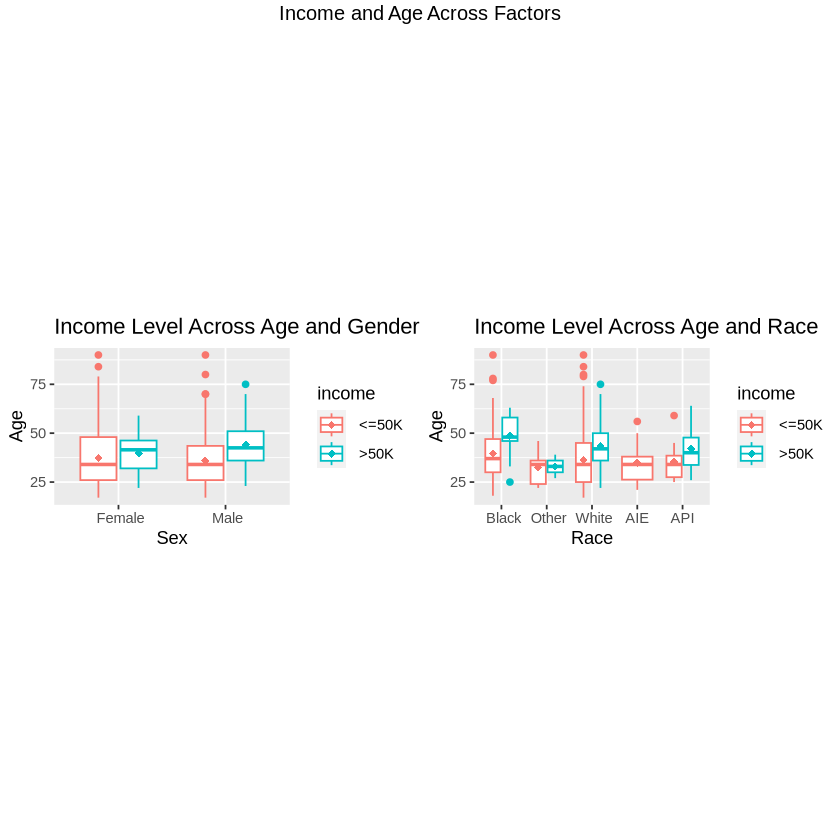

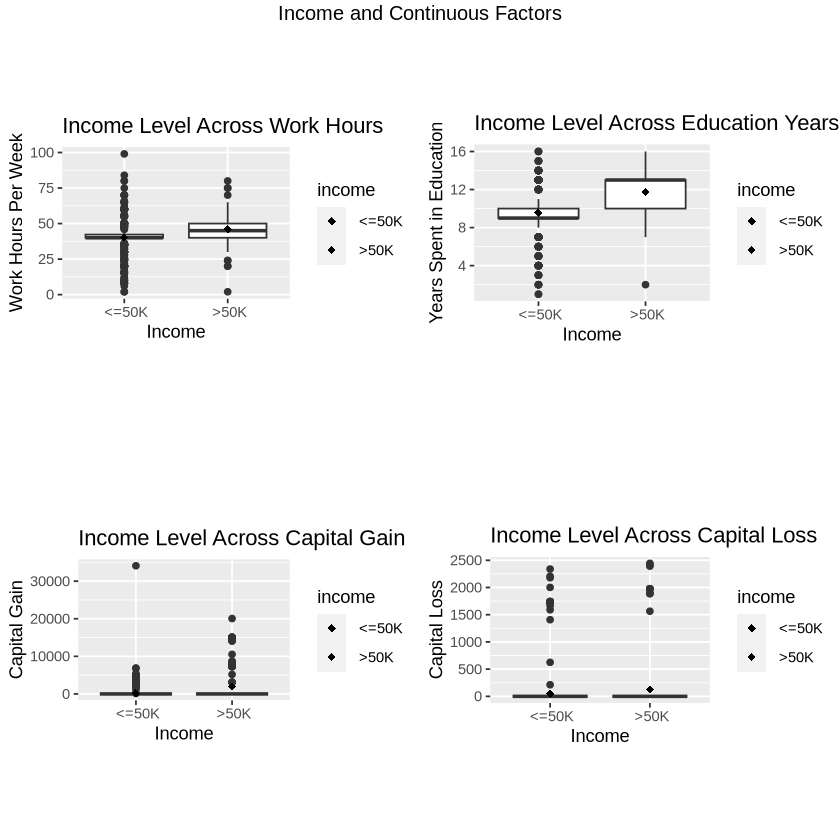

In [9]:
grid.arrange(plot1,plot2, ncol=2, top = "Income and Age Across Factors") 
grid.arrange(plot3, plot4, plot5, plot6, top = "Income and Continuous Factors")

Based on the boxplots above, we have gained some useful insights:
- **Income and Age Across Factors**: Across the income levels within each categorical variable, individuals who have yearly income greater than 50,000 dollars tend to be older than those less than 50,000 dollars. Moreover, among all races, black people are generally older to have an annual income greater than 50,000 dollars. Notably, all American-Indian-Eskimoins have an yearly income less than 50,000 dollars in our sample.
- **Income Across Continuous Factors**: These boxplots show the distribution of income levels against continuous variables. People with higher income (> 50,000) tend to have longer work hours per week. Meanwhile, individuals who spend more years on education are more likely to have annual income greater than $50,000. Since only a minority of individuals in the sample have reported capital gains or losses, we observe more discrete points than actual boxes. These points are right skewed , underscoring their infrequency within the sample.


## Methods and Plan
To predict whether an individual's annual income is greater than 50000 dollars or not based on the input variables `age`, `race`, `capital_gain`, `capital_loss`, `race`, `sex`, `edu_num` and `hrs`, the **binary logistic regression** method is proposed as an appropriate analytical tool. 

- Why is this method appropriate?
**Binary logistic regression** is utilized for scenarios where there are two possible outcomes in the response variable. It fits my situation where it requires to predict the outcome of whether the annual income is greater than 50000 dollars or not. The explanatory variables including `age`, `race`, `capital_gain`, `capital_loss`, `race`, `sex`, `edu_num` and `hrs`, have both types of categorical and numeric. These selected vaiables has little multicollinearity by intuition and the observations (different individuals) are independent. Hence, for this problem logistic regression is the most appropriate model to predict the annual income.

- Assumptions
Binary logistic regression assumes that the relationship between the predictors and the log odds of the outcome is linear. This requires discretion while interpreting the coefficients for each predictor. As stated before, the assumption of independence of observations is essential. Each data point in the dataset should be independent of others to ensure the reliability of the logistic model.

- Potential Limitations & Weakness
One significant setback arises from the sample itself concerning the uneven distribution of the input variable `race`. The level "white" is overwhelmingly dominant (685 in 800 training dataset), which can affect the predictions as the coefficients in other races may have the problem of overfitting or underfitting.

Another notable limitation is that logistic regression's assumption of linear relationship between the predictors and the log odds of the outcome. If the true result is not linear, the model might not provide an accurate representation. Meanwhile, there are some significant outliers in the sample, the performance of the  model may be heavily impacted.

Nevertheless, despite these limitations, binary logistic regression remains fitting for this sample due to its ability to handle binary outcomes and multiple predictors in comparison with the simple linear regression. By effectively modeling the relationship between the predictors and annual incomes, it promotes the identification of the most influential factors contributing to the yearly income, enabling better understanding in the factors affecting incomes.

### Implementation of a proposed model
I will implement binary logistic model for the sample.

In [10]:
adult_sample <- adult_sample |> 
    mutate(income = as.integer(ifelse(income == " <=50K", 0, 1)))
model <- glm(income ~ age + sex + edu_num + hrs + capital_gain + capital_loss,
             data = adult_sample, family = "binomial")
summary(model)


Call:
glm(formula = income ~ age + sex + edu_num + hrs + capital_gain + 
    capital_loss, family = "binomial", data = adult_sample)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5469  -0.5990  -0.3528  -0.1279   2.6995  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -9.848e+00  7.457e-01 -13.207  < 2e-16 ***
age           4.583e-02  7.496e-03   6.113 9.75e-10 ***
sex Male      1.435e+00  2.480e-01   5.787 7.16e-09 ***
edu_num       3.701e-01  4.194e-02   8.824  < 2e-16 ***
hrs           3.583e-02  8.336e-03   4.298 1.72e-05 ***
capital_gain  2.385e-04  4.684e-05   5.093 3.53e-07 ***
capital_loss  2.869e-04  2.012e-04   1.426    0.154    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1061.36  on 999  degrees of freedom
Residual deviance:  760.34  on 993  degrees of freedom
AIC: 774.34

Number of Fisher Scoring iterations: 5


In [11]:
model_results  <-
    tidy(model) %>% 
    mutate(exp.estimate = exp(estimate)) %>% 
    mutate_if(is.numeric, round, 3)

model_results

term,estimate,std.error,statistic,p.value,exp.estimate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-9.848,0.746,-13.207,0.000,0.000
age,0.046,0.007,6.113,0.000,1.047
sex Male,1.435,0.248,5.787,0.000,4.201
edu_num,0.370,0.042,8.824,0.000,1.448
hrs,0.036,0.008,4.298,0.000,1.036
capital_gain,0.000,0.000,5.093,0.000,1.000
capital_loss,0.000,0.000,1.426,0.154,1.000


This logistic regression model explores the association between various factors including age, gender, years spent on education, working hours, capital gain and loss, and whether the annual income is greater than $ 50k. All the input variables expect for `capital_loss` are significantly associated with the amount of annual income.  An unexpected outcome is the tiny coefficents of `capital_gain` and `captial_loss`, indicating they have a very small effect on annual income. 